# Batch Optimization of Anti-Corrosion Coatings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgbaird/honegumi/blob/main/docs/curriculum/tutorials/batch/batch-bo-tutorial.ipynb)

In [61]:
try:
    import google.colab
    %pip install ax-platform matplotlib
except:
    print("Not running in Google Colab")

Not running in Google Colab



Many high-performing materials suffer from poor corrosion resistance, which limits their use in real-world applications. Anti-corrosion coatings are a common solution that can be adapted to protect a given material in a number of harsh environments. You have the task of designing an anti-corrosion coating for a new material that needs to withstand a relatively high-temperature corrosive environment. You decided to simulate the corrosive environment in the lab and test a number of different coatings to see which one performs the best. Based on the lab space, you find that you can test up to six coatings in a single test, allowing three replicates of two coating compositions to be tested simultaneously.

You believe Bayesian optimization can help you in this task and decide to put together an optimization script using Honegumi to help solve this problem.

You identify the following tunable parameters for this problem:

| | **Parameter Name** | **Bounds**  |
|------|--------------------|-------------|
| x1   | Resin Fraction              | [0, 1]          |
| x2   | Inhibitor Fraction          | [0, 1]          |
| x3   | Insulator Fraction          | [0, 1]          |
| x4   | Stabilizer Fraction         | [0, 0.1]        |
| x5   | Coating Thickness           | [0.1, 10]       |

Looking through the literature, you identify constraints on the relative fractions of each component that should reduce the size of the search space and make the optimization task easier. Notably, you find that the best materials keep the `Resin Fraction` greater than the `Inhibitor Fraction` and the `Insulator Fraction` and decide to incorporate this as a constraint.

A dummy objective function that emulates the results of the corrosion experiment has been constructed in the code cell below. To simulate sample variability, random noise is added to the output of the function on call. Although we can easily find optimal values using the equations, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [62]:
import numpy as np

def gauss(x, mean, std):
    return np.exp(-(((x - mean) / std) ** 2))

def simulate_corrosion(x1, x2, x3, x4, x5):
    """
    Calculate the corrosion damage based on the input parameters.

    Args:
        x1 (float): the fraction of resin used in the coating formulation
        x2 (float): the fraction of inhibitor used in the coating formulation
        x3 (float): the fraction of insulator used in the coating formulation
        x4 (float): the fraction of stabilizer used in the coating formulation
        x5 (float): the coating thickness

    Returns:
        dict: the measured corrosion damage and  uncertainty
    """
    # score = float(
    #     1/(np.exp(-40*(x1-0.42)**2) + np.exp(-24*(x1-0.75)**2) + 0.1) +
    #     1/(np.exp(-30*(x2-0.22)**2) + np.exp(-1000*(x2-0.22)**2) + np.exp(-800*(x2-0.42)**2) + 0.15) +
    #     1/(np.exp(-25*(x3-0.27)**2) + np.exp(-1000*(x3-0.27)**2) + np.exp(-150*(x3-0.37)**2) +1) +
    #     1/(np.exp(-400*(x4-0.08)**2) +1) + 0.5*x4 +
    #     1/(np.exp(-(x5-8)**2) + 0.05*x5 + 0.3)
    # ) - 3.18

    score = float(
        gauss(x1, 0.42, 0.1) + gauss(x2, 0.75, 0.1) + gauss(x3, 0.22, 0.03) \
        + gauss(x4, 0.42, 0.03) + gauss(x5, 0.27, 0.03)
    )
    
    return (2.7 - score, abs(np.random.normal(0.0, 0.1)))

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the coating parameters. From the description, we observe that our problem is a **single objective** optimization problem with a **constraint on the fractional sum of coating components** and an **ordering constraint** on the relative fractions of each component. As there is room for several samples to be tested in parallel, **batch optimization** could make the approach more efficient. Lastly, it is expected that the results will be noisy, so you decide to use a **Fully Bayesian** model to make the optimization process more robust.

![batch_fullybayesian_selections](batch_fullybayesian_selection.png)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# MOD:` has been added along with a brief description of the change.

> NOTE: This problem uses a fully Bayesian GP model, which is more computationally demanding than the standard GP model. As such, the number of trials has been limited for demonstration purposes.

In [ ]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.modelbridge.factory import Models
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy


obj1_name = "corrosion_score" # MOD: update objective name

# MOD: remove the branin dummy objective function, we will use the above function

total = 1.0 # MOD: update total component fraction

gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL,
            num_trials=6,
            min_trials_observed=3,
            max_parallelism=5,
            model_kwargs={"seed": 999},
            model_gen_kwargs={},
        ),
        GenerationStep(
            model=Models.FULLYBAYESIAN,
            num_trials=-1,
            max_parallelism=3,
            should_deduplicate=True, # MOD: reduce duplicate suggestions
            model_kwargs={"num_samples": 256, "warmup_steps": 256},
        ),
    ]
)

ax_client = AxClient(generation_strategy=gs,
                     random_seed=42) # MOD: add random seed for reproducibility

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [0.0, total]}, # MOD: update param
        {"name": "x2", "type": "range", "bounds": [0.0, total]}, # MOD: update param
        {"name": "x3", "type": "range", "bounds": [0.0, total]}, # MOD: add param
        {"name": "x5", "type": "range", "bounds": [0.1, 10.0]}, # MOD: add param
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=True),
    },
    parameter_constraints=[
        f"x1 + x2 + x3 <= {total}", # MOD: update composition constraint
        "x1 >= x2", # MOD: update order constraint
        "x1 >= x3", # MOD: add order constraint
    ],
)

batch_size = 2

for _ in range(15): # MOD: decrease number of iterations

    parameterizations, optimization_complete = ax_client.get_next_trials(batch_size)
    for trial_index, parameterization in list(parameterizations.items()):
        
        # MOD: pull all added parameters from the parameterization
        x1 = parameterization["x1"]
        x2 = parameterization["x2"]
        x3 = parameterization["x3"]
        x4 = total - (x1 + x2 + x3) # MOD: apply composition constraint
        x5 = parameterization["x5"]

        results = simulate_corrosion(x1, x2, x3, x4, x5)
        ax_client.complete_trial(trial_index=trial_index, raw_data=results)

best_parameters, metrics = ax_client.get_best_parameters()

> NOTE: The output of the above cell has been hidden in the interest of clarity.

[WARNING 08-17 14:17:59] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


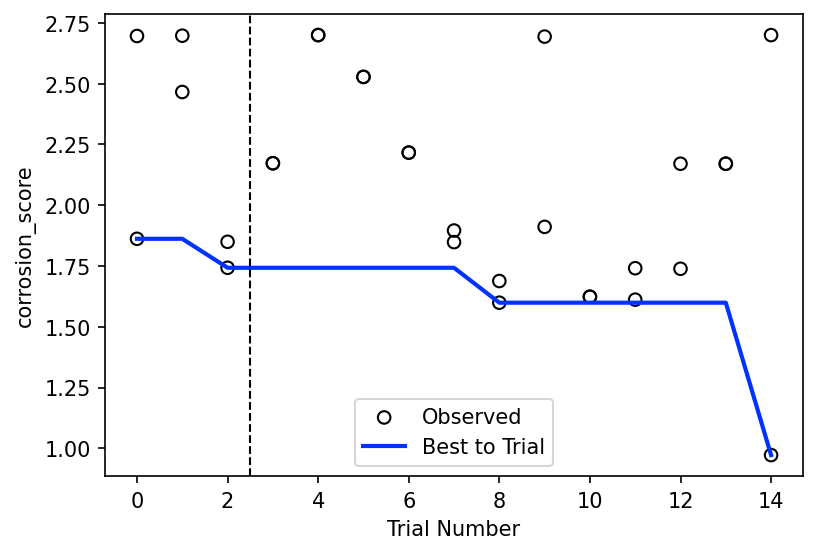

In [64]:
import matplotlib.pyplot as plt

objectives = ax_client.objective_names
df = ax_client.get_trials_data_frame()[objectives]
df.index = df.index // batch_size

best_to_trial = np.minimum.accumulate(df.groupby(df.index).min()) # change if maximizing

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(df.index, df, ec="k", fc="none", label="Observed")
ax.plot(df.index.unique(), best_to_trial, color="#0033FF", lw=2, label="Best to Trial")

ax.axvline(6//batch_size-0.5, color="k", ls="--", lw=1) # MOD: mark end of SOBOL trials

ax.set_xlabel("Trial Number")
ax.set_ylabel(objectives[0])
ax.legend()
plt.show()

## Show the Best Parameters

After our optimization loop has completed, we can use the model to find the best parameters and their corresponding corrosion score value. These will be our optimal coating formulation parameters that we use in the anti-corrosion coating going forward.

In [67]:
ax_client.get_best_trial()

[INFO 08-17 14:18:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0
Sample: 100%|██████████| 512/512 [00:11, 46.43it/s, step size=2.96e-01, acc. prob=0.890]


(29,
 {'x1': 0.4130550962025621,
  'x2': 0.3836788679559248,
  'x3': 0.2032660357929819,
  'x5': 10.0},
 ({'corrosion_score': 1.1320205624828028},
  {'corrosion_score': {'corrosion_score': 0.01447904637663158}}))

## Next Steps

Interested in taking this further? Try to implement the following on your own!

1. How does increasing the batch size affect the optimization performance? Are larger or smaller batches more advantageous for getting good results quickly?

2. How does the default model compare to the fully Bayesian model on this task?